In [56]:
import serial
import time
import random
import pandas as pd

# Request codes
MOTOR_CONTROL = 1000
STATE_REQUEST = 2000
RESET_CODE = 6666

# Response codes
NOMINAL = 1111
ERROR = 9999

# Constants for communication
END_CHAR = '>'
MESSAGE_TERMINATOR = '\n'
DELIMITER = ','


def read_serial_line(serial_device: serial.Serial, print_message=True):
    """
       Reads data from Serial (from Arduino) with a safe check for end char

       Args:
           serial_device (serial.Serial): The Serial device
       Returns:
           (str): The output of the line, or None if invalid message
    """
    data_line = serial_device.readline().decode().strip()
    if END_CHAR in data_line:
        data_list = data_line.replace(END_CHAR, '').split(DELIMITER)
    else:
        data_list = None
    if print_message:
        print('Reading message: ' + str(data_list))
    return data_list


def write_serial_line(serial_device: serial.Serial, code_array, write_timeout=3, print_message=True):
    """
    Args:
        serial_device (serial.Serial): The Serial device
        code_array (list): The sequence of codes/values to send to Arduino

    Returns:
        (bool): True for successful write, False for timeout

    """
    message = ','.join([str(x) for x in code_array]) + END_CHAR + MESSAGE_TERMINATOR

    # Track write time or timeout
    write_success = True
    write_start = time.time()
    serial_device.write(str(message).encode())

    # Attempt to write message
    if print_message:
        print('Writing serial message: ' + str(code_array))
    while (serial_device.out_waiting > 0) and (time.time() - write_start < write_timeout):
        time.sleep(0.05)
    if (time.time() - write_start > write_timeout) and (serial_device.out_waiting > 0):
        write_success = False

    # Reset buffer
    serial_device.reset_output_buffer()

    return write_success


def initialize_serial(serial_port='/dev/cu.usbmodem14101', baud_rate=9600, timeout=2):
    serial_device = serial.Serial(port=serial_port, baudrate=baud_rate, timeout=timeout)
    serial_device.flush()
    time.sleep(2)
    return serial_device


def map_message_to_dict(timestamp, input_message):
    final_dict = {}
    if input_message is not None:
        final_dict = {
            'timestamp': timestamp,
            'state': input_message[0],
            'arduino_duration': input_message[1],
            'motor_1_position': input_message[2],
            'motor_2_position': input_message[3],
            'I_ivp_1': input_message[4],
            'V_ivp_1': input_message[5],
            'P_ivp_1': input_message[6]
        }
    return final_dict


def loop(arduino, runtime=12):
    # Run start
    run_start = time.time()
    data_dict_list = []
    last_motor_interval = 0
    last_measure_interval = -1
    motor_frequency = 2
    measure_frequency = 1
    # Set timeouts
    response_timeout = 3
    reset_timeout = 5
    abort = False
    expecting_response = False

    # Check for new messages to log
    while time.time() - run_start < runtime and not abort:
        # if arduino.in_waiting > 0:
        #    data_dict_list.append(map_message_to_dict(time.time(), read_serial_line(arduino, print_message=False)))

        # Calculate intervals
        motor_interval = round(time.time() - run_start)//motor_frequency
        measure_interval = round(time.time() - run_start)//measure_frequency

        # every N seconds adjust motor position randomly
        if motor_interval != last_motor_interval:
            motor_1_position = random.randint(0, 181)
            motor_2_position = random.randint(0, 181)
            write_serial_line(arduino, [MOTOR_CONTROL, motor_1_position, motor_2_position], print_message=False)
            # print([1000, motor_1_position, motor_2_position])
            last_motor_interval = motor_interval
            expecting_response = True

        # otherwise, request a measurement every N seconds
        else:
            if measure_interval != last_measure_interval:
                write_serial_line(arduino, [STATE_REQUEST], print_message=False)
                last_measure_interval = measure_interval
                expecting_response = True

        # Wait for response from arduino before proceeding
        if expecting_response:
            wait_start = time.time()
            while arduino.in_waiting <= 0 and time.time() - wait_start < response_timeout:
                time.sleep(0.001)
            # Case for successful response
            if arduino.in_waiting > 0:
                data_dict_list.append(map_message_to_dict(time.time(), read_serial_line(arduino, print_message=False)))
                expecting_response = False
            # If no response, send a reset request
            else:
                print('WARNING: Arduino unresponsive, requesting reset...')
                write_serial_line(arduino, [RESET_CODE])
                # Verify the reset
                wait_start = time.time()
                while arduino.in_waiting <= 0 and time.time() - wait_start < reset_timeout:
                    time.sleep(0.005)
                if arduino.in_waiting > 0:
                    print('SUCCESS: Arduino reset successfully.')
                    data_dict_list.append(map_message_to_dict(time.time(), read_serial_line(arduino, print_message=False)))
                else:
                    print('FATAL ERROR: Arduino unresponsive to reset.')
                    abort = True
    if abort:
        print('\nABORTING TEST AND WRITING DATA')
    # Reset at end
    else:
        write_serial_line(arduino, [RESET_CODE], print_message=False)

    return pd.DataFrame(data_dict_list)

In [87]:
if __name__ == '__main__':
    print('\nARDUINO CONTROL TESTING')
    print('-------------------------')
    # Initialize serial port
    print('\nIniitalizing device...')
    serial_port = '/dev/cu.usbmodem14101'
    baud_rate = 9600
    timeout = 5
    arduino = initialize_serial(serial_port=serial_port, baud_rate=baud_rate, timeout=timeout)
    print('\t - SUCCESS: Device initialized.')

    # Run a loop where motor position incremented every 5 seconds, print out message
    print('\nBeginning loop sequence...')
#     data = loop(arduino, runtime=15)
    print('\t - Loop complete.')

    # Add relative time to returned data and print out
#     data['t_relative'] = data['timestamp'] - data['timestamp'].iloc[0]
    print('\nData broadcasted by Arduino:\n')


ARDUINO CONTROL TESTING
-------------------------

Iniitalizing device...
	 - SUCCESS: Device initialized.

Beginning loop sequence...
	 - Loop complete.

Data broadcasted by Arduino:



In [143]:
def demo_movement(arduino):
    time.sleep(3)
    write_serial_line(arduino, [1000, 90, 90])
    time.sleep(2)
    write_serial_line(arduino, [1000, 0, 135])
    time.sleep(2)
    write_serial_line(arduino, [1000, 45, 180])
    time.sleep(2)
    write_serial_line(arduino, [1000, 90, 30])
    time.sleep(2)
    write_serial_line(arduino, [1000, 135, 60])
    time.sleep(2)
    write_serial_line(arduino, [1000, 0, 30])
    time.sleep(2)
    write_serial_line(arduino, [1000, 60, 120])
    time.sleep(2)
    write_serial_line(arduino, [1000, 120, 45])
    time.sleep(2)
    write_serial_line(arduino, [1000, 90, 90])

In [144]:
demo_movement(arduino)

Writing serial message: [1000, 90, 90]
Writing serial message: [1000, 0, 135]
Writing serial message: [1000, 45, 180]
Writing serial message: [1000, 90, 30]
Writing serial message: [1000, 135, 60]
Writing serial message: [1000, 0, 30]
Writing serial message: [1000, 60, 120]
Writing serial message: [1000, 120, 45]
Writing serial message: [1000, 90, 90]


In [139]:
write_serial_line(arduino, [1000, 120, 45])

Writing serial message: [1000, 120, 45]


True

In [80]:
data = data[data.columns].astype(float)

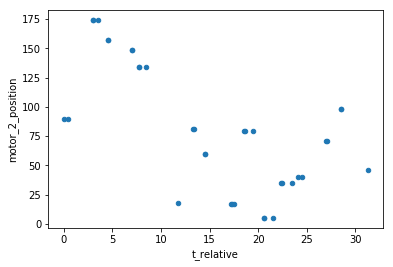

In [82]:
data.plot.scatter(x='t_relative', y='motor_2_position')